In [ ]:
# ====================================================================================== #
# Module for pipelineing the analysis of causal graphs with neighborhood triplets. Sandbox.
# Author: Clemens Baldzuhn
# ====================================================================================== #

In [1]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *


In [2]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)
dt, dx, gridix = mesoscale


In [3]:
def calculate_significant_edges(self_edges, pair_edges, summary = False):
        
    significant_edges = [[] for _ in range(degree+1)]
    counts = np.zeros(degree+1)
    
    #self edges
    for poly, (te, te_shuffle) in self_edges.items():
        if (te > te_shuffle).mean() >= (95 / 100):
            significant_edges[0].append([(poly, poly), te])
    counts[0] = len(self_edges)

    #pair edges
    for pair, (te, te_shuffle) in pair_edges.items():
        d = pair[2]
        if 1 <= d <= degree:
            counts[d] += 1
            if (te > te_shuffle).mean() >= (95/100): #threshold!
                significant_edges[d].append([(pair[0], pair[1]), te])            
    
    #ratio dataframe 
    if summary:
        df = pd.DataFrame(
            {
                "Degree": np.arange(degree+1),
                "Total edges": counts,
                "Significant edges": [len(edges) for edges in significant_edges],
            }
        )
        df["Ratio"] = round(df["Significant edges"] / df["Total edges"], 3)
        
        return df, significant_edges
    
    else:
        return significant_edges

In [4]:
degree = 1
ava_1 = Avalanche(dt = dt, dx = dx, gridix=gridix, degree = degree, triples=False,construct_avalanche=False,  setup_causalgraph=True)
ava_1_self = ava_1.self_edges
ava_1_pair = ava_1.pair_edges

df_1, sign_edges = calculate_significant_edges(ava_1_self, ava_1_pair, summary = True)

#triples
ava_2 = Avalanche(dt = dt, dx = dx, gridix=gridix, degree = degree, triples=True, construct_avalanche=False,  setup_causalgraph=True)
ava_2_self = ava_2.self_edges
ava_2_pair = ava_2.pair_edges


/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [5]:
def extract_significant_edges(ava_pairs, ava_triples):
    significant_pairs = []
    for pair, (te, te_shuffle) in ava_pairs.items():
        if (te > te_shuffle).mean() >= (95/100): #threshold!
            significant_pairs.append([(pair[0], pair[1]), te])
    
    significant_triples = []
    for triplet, (te, te_shuffle) in ava_triples.items():
        if (te > te_shuffle).mean() >= (95/100): #threshold!
            significant_triples.append([(triplet[0], triplet[1], triplet[2]), te])
    
    return significant_pairs, significant_triples

significant_pairs, significant_triples = extract_significant_edges(ava_1_pair, ava_2_pair)

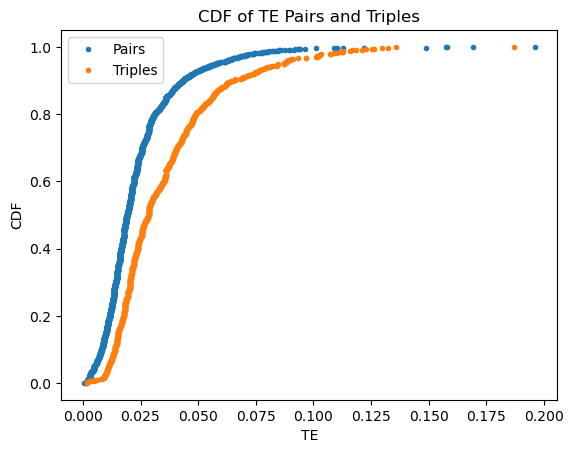

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


def plot_ecdf(significant_pairs, significant_triples):
    tes = [te for _, te in significant_pairs]    
    mean_te = np.array(tes).mean()
    
    ecdf = sm.distributions.ECDF(tes)
    x = np.sort(tes)
    y = ecdf(x)

    plt.plot(x, y, 'o', markersize=3, label='Pairs')
    
    triple_tes = [te for _, te in significant_triples]
    triple_mean_te = np.array(triple_tes).mean()
    
    triple_ecdf = sm.distributions.ECDF(triple_tes)
    triple_x = np.sort(triple_tes)
    triple_y = triple_ecdf(triple_x)
    
    plt.plot(triple_x, triple_y, 'o', markersize=3, label='Triples')
    
    plt.title('CDF of TE Pairs and Triples')
    plt.xlabel('TE')
    plt.ylabel('CDF')
    plt.legend()

plot_ecdf(significant_pairs, significant_triples)

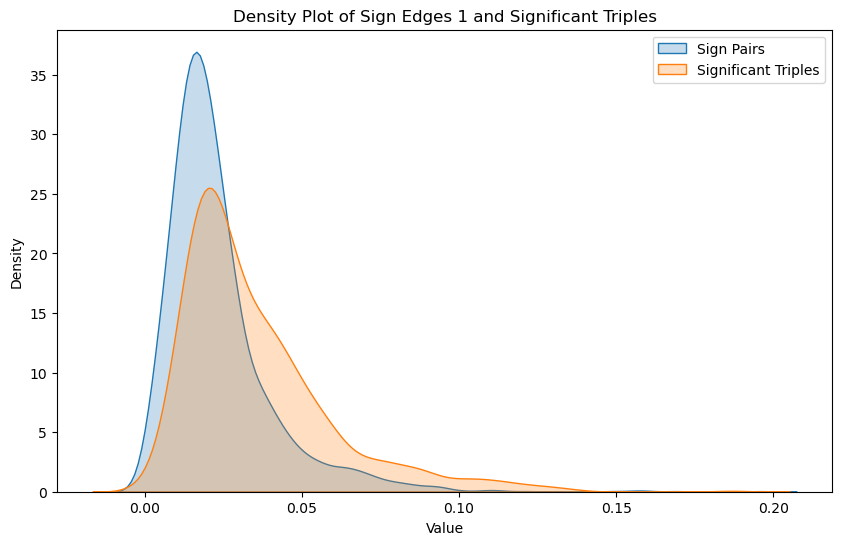

In [8]:
# todo: plot density

import seaborn as sns
import matplotlib.pyplot as plt
tes_pairs = [te for _, te in significant_pairs]    
tes_triples = [te for _, te in significant_triples]

# Create a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(tes_pairs, label='Sign Pairs', shade=True)
sns.kdeplot(tes_triples, label='Significant Triples', shade=True)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Sign Edges 1 and Significant Triples')
plt.legend()

# Display the plot
plt.show()